In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from ivae_scorer.utils import set_all_seeds
import seaborn as sns
import dotenv
from pathlib import Path
import numpy as np
import pandas as pd

project_path = Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("results")
data_path = project_path.joinpath("data")
figs_path = results_path.joinpath("figs")
tables_path = results_path.joinpath("tables")

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

2024-01-12 06:35:40.311989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
models = ["ivae_kegg", "ivae_reactome"] + [f"ivae_random-{frac:.1f}" for frac in np.arange(0.1, 1.0, 0.1)]
models

['ivae_kegg',
 'ivae_reactome',
 'ivae_random-0.1',
 'ivae_random-0.2',
 'ivae_random-0.3',
 'ivae_random-0.4',
 'ivae_random-0.5',
 'ivae_random-0.6',
 'ivae_random-0.7',
 'ivae_random-0.8',
 'ivae_random-0.9']

In [3]:
# Metrics

metric_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_metrics.pkl")) for m in models
]
metric_scores = pd.concat(metric_scores, axis=0, ignore_index=True)
# metric_scores = metric_scores.query("metric=='mse'")
# metric_scores["model"] = metric_scores["model"].str[-2:]
# metric_scores["score"] = metric_scores["score"].apply(lambda x: -np.log2(x))
metric_scores.head()

,seed,metric,split,score,model
0,0,loss,train,6.537294,ivae_kegg
1,0,mse,train,0.000363,ivae_kegg
2,0,loss,val,6.538196,ivae_kegg
3,0,mse,val,0.000364,ivae_kegg
4,0,loss,test,6.593009,ivae_kegg


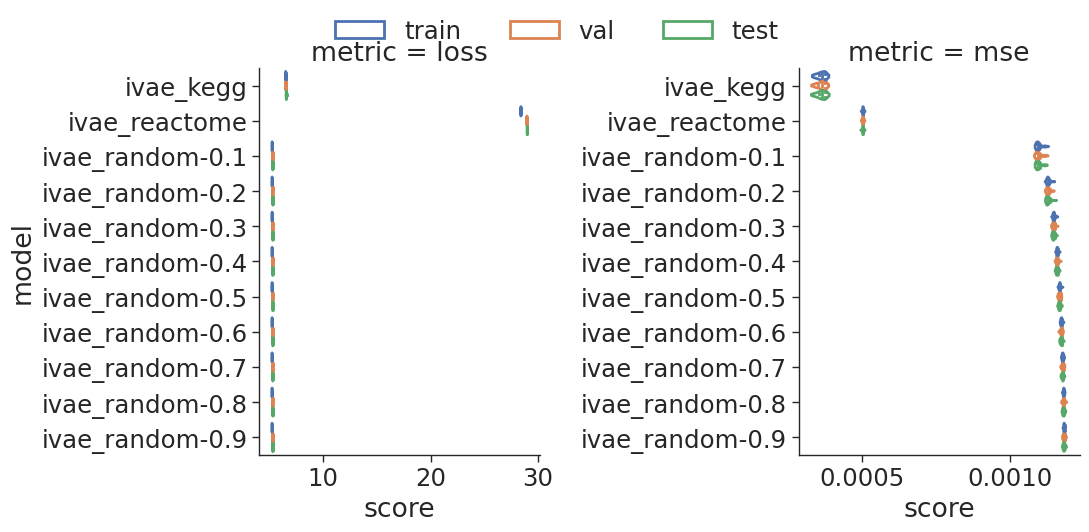

In [4]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.6

g = sns.catplot(
    data=metric_scores,
    kind="violin",
    col="metric",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=False,
    sharex=False,
    y="model",
    x="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
)

sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.5, 0.9),
    ncol=3,
    title=None,
    frameon=False,
)

In [5]:
# clustering

clustering_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_clustering.pkl")) for m in models
]
clustering_scores = pd.concat(clustering_scores, axis=0, ignore_index=True)
clustering_scores.head()

,split,layer,score,model
0,train,1,0.614234,ivae_kegg
1,train,1,0.674097,ivae_kegg
2,train,1,0.671048,ivae_kegg
3,train,1,0.621495,ivae_kegg
4,train,1,0.633413,ivae_kegg


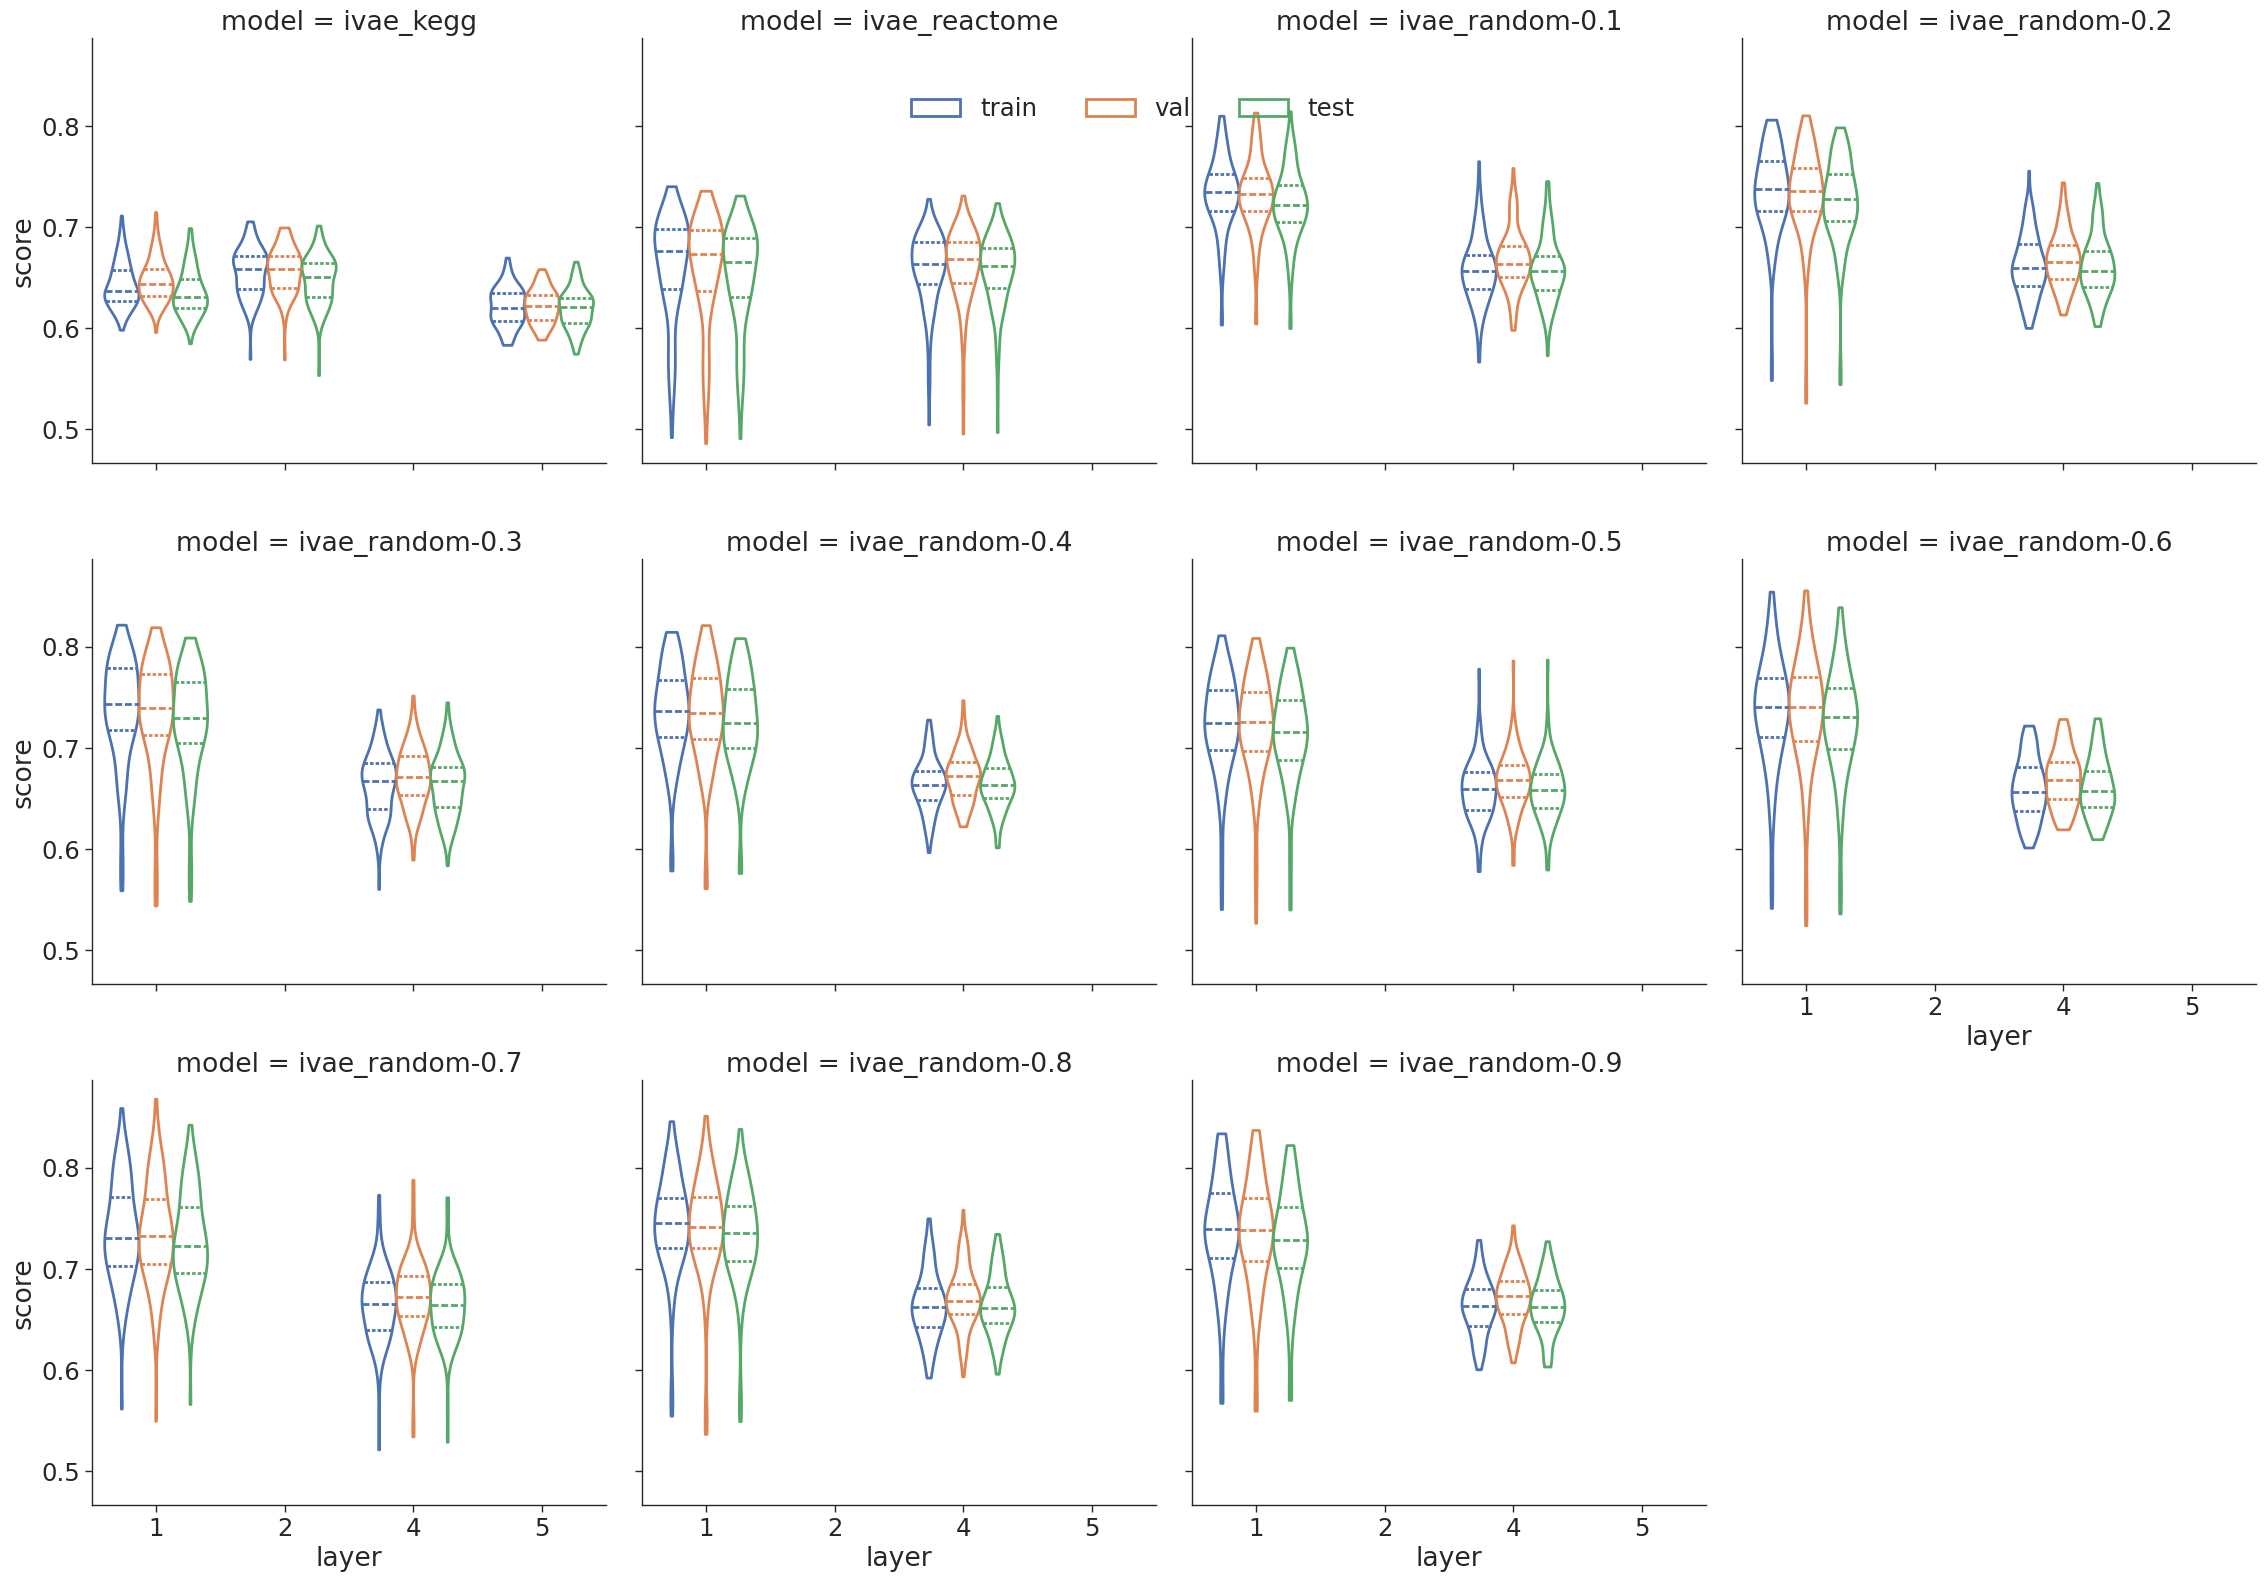

In [9]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.6

g = sns.catplot(
    data=clustering_scores,
    kind="violin",
    col="model",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4
)

sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.5, 0.9),
    ncol=3,
    title=None,
    frameon=False,
)

In [7]:
# informed

informed_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_informed.pkl")) for m in models
]
informed_scores = pd.concat(informed_scores, axis=0, ignore_index=True)
informed_scores.head()

,split,layer,score,model
0,train,1,0.799125,ivae_kegg
1,train,1,0.793012,ivae_kegg
2,train,1,0.799075,ivae_kegg
3,train,1,0.795838,ivae_kegg
4,train,1,0.796461,ivae_kegg


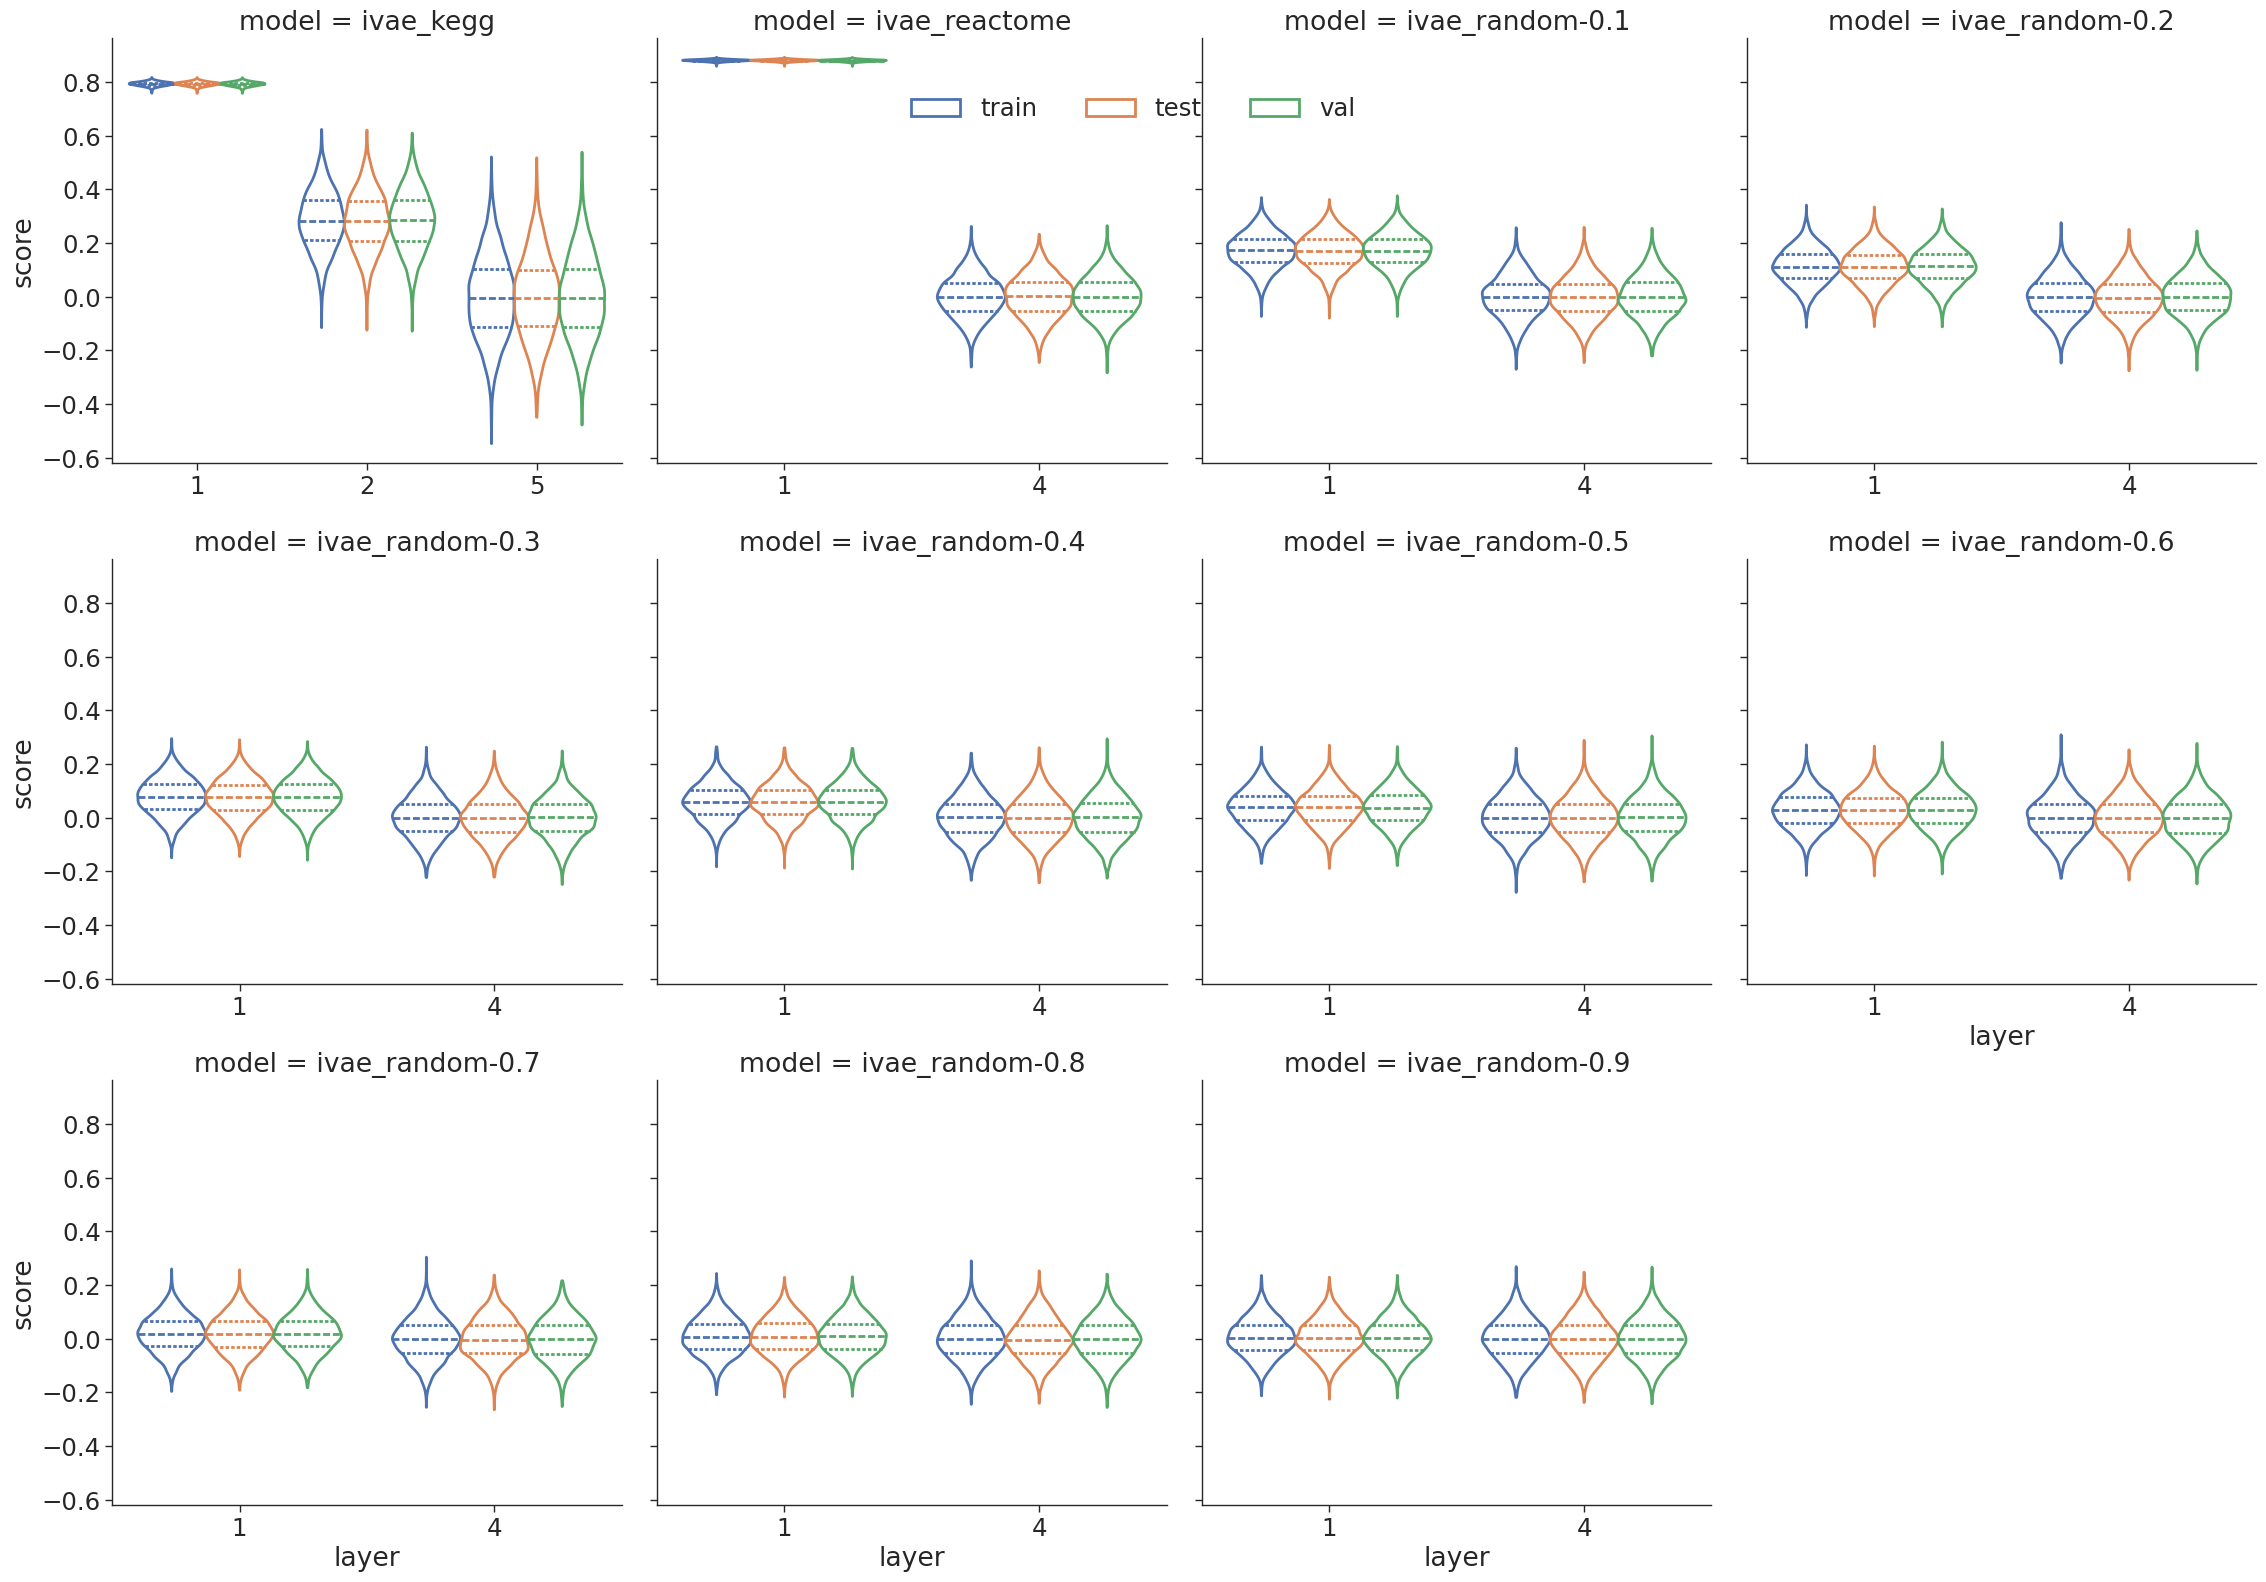

In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.6

g = sns.catplot(
    data=informed_scores,
    kind="violin",
    col="model",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4
)

sns.move_legend(
    g,
    "lower center",
    bbox_to_anchor=(0.5, 0.9),
    ncol=3,
    title=None,
    frameon=False,
)